# 时间序列分析第七次作业

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入和平稳性检验（PP检验）
导入P198 T6 1750年至1849年瑞典人口出生率为实验数据  
首先通过图检验判断平稳性、再进一步使用PP检验判断是否为平稳性数据  
PP检验:  
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

均值：6.69，方差：34.2139
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.880
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.50 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，数据是平稳数据。


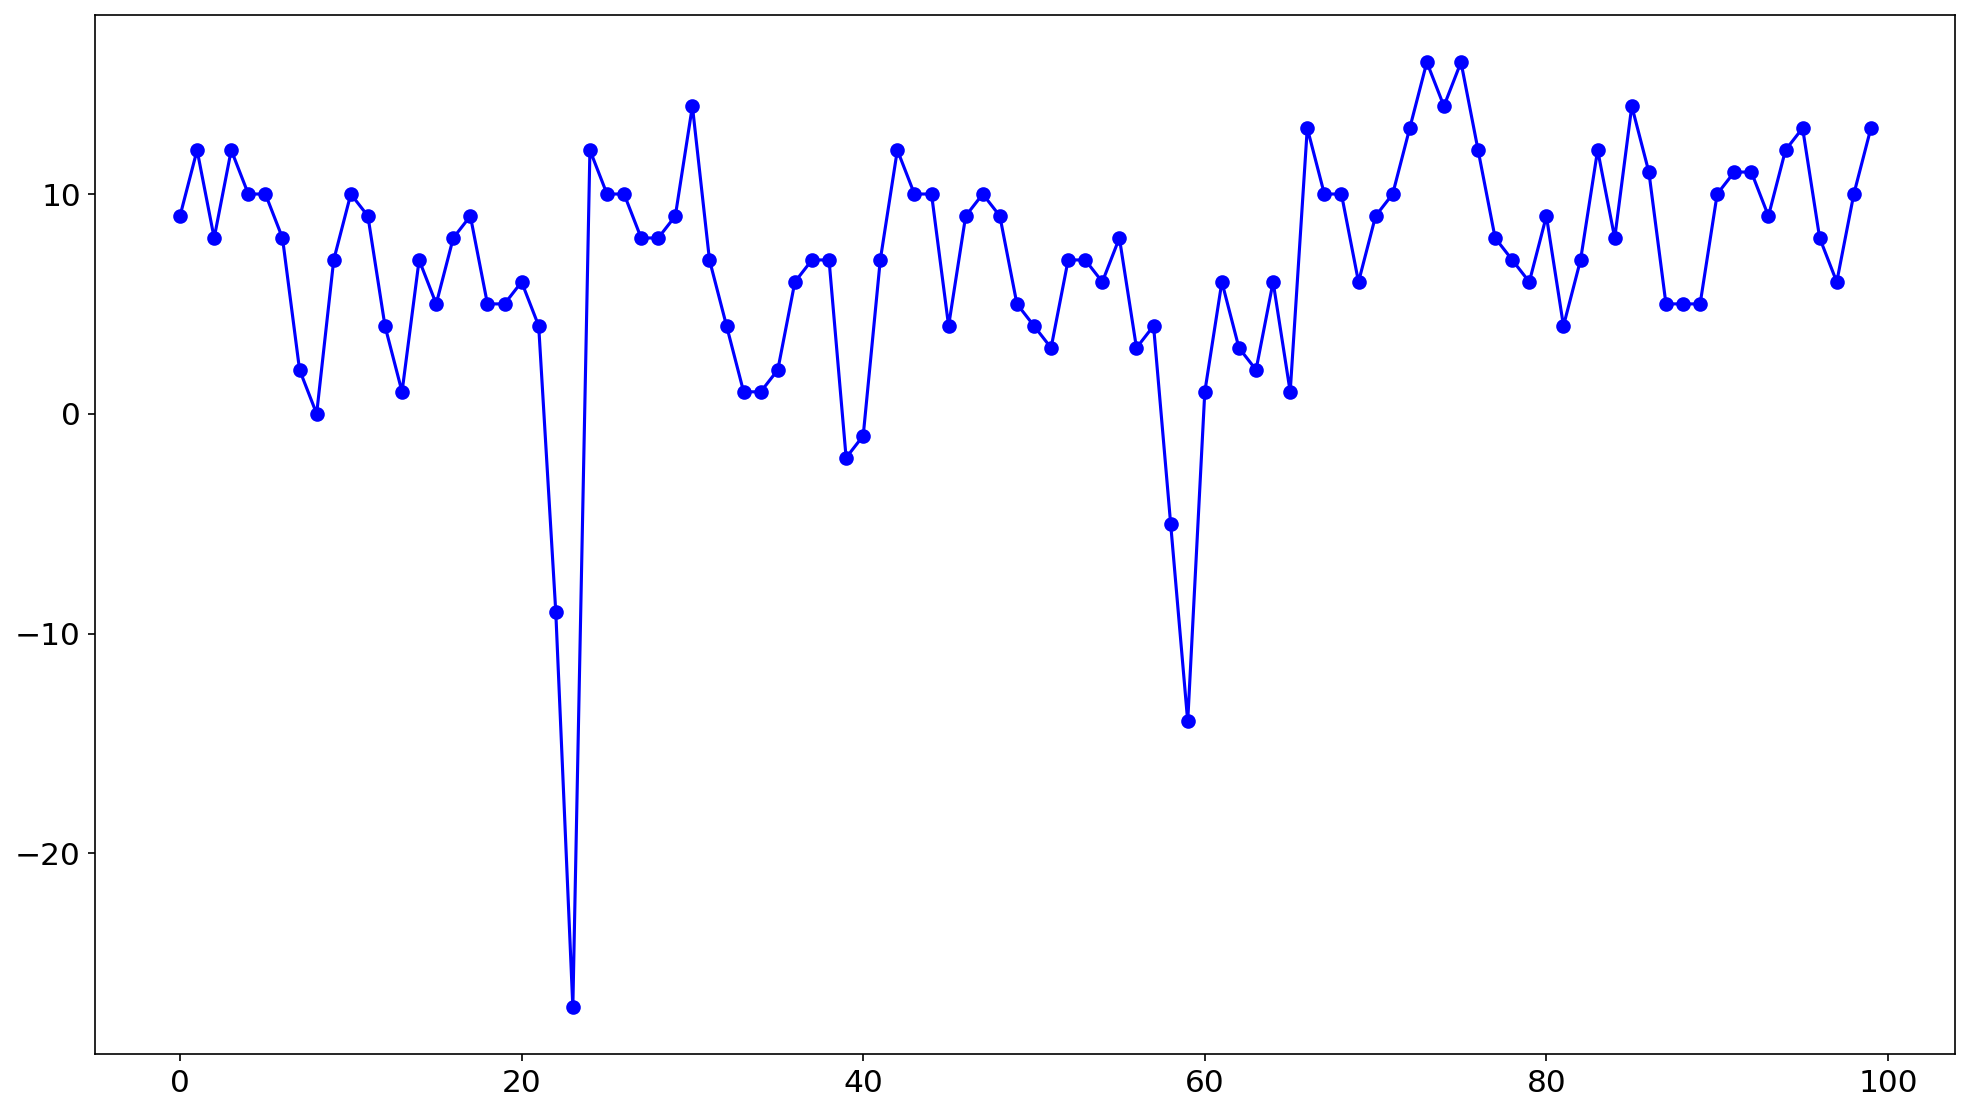

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from arch.univariate import arch_model
import scipy.stats as st
from scipy.stats import jarque_bera

# 数据导入，P198 T6 1750年至1849年瑞典人口出生率
data = [9, 12, 8, 12, 10, 10, 8, 2, 0, 7, 10, 9, 4, 1, 7, 5, 8, 9, 5, 
        5, 6, 4, -9, -27, 12, 10, 10, 8, 8, 9, 14, 7, 4, 1, 1, 2, 6, 7, 
        7, -2, -1, 7, 12, 10, 10, 4, 9, 10, 9, 5, 4, 3, 7, 7, 6, 8, 3, 
        4, -5, -14, 1, 6, 3, 2, 6, 1, 13, 10, 10, 6, 9, 10, 13, 16, 14, 16, 
        12, 8, 7, 6, 9, 4, 7, 12, 8, 14, 11, 5, 5, 5, 10, 11, 11, 9, 12, 
        13, 8, 6, 10, 13]

# 计算均值和方差
mean = np.mean(data)
variance = np.var(data)
print(f'均值：{mean}，方差：{variance}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='序列图.png')

# 数据做 PP 检验
pp = PhillipsPerron(data)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，数据是平稳数据。")
else:
    print("不能拒绝原假设，数据可能是非平稳数据。")

## 二、纯随机检验
已经判断序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [9]:
# 纯随机检验
LB = acorr_ljungbox(data, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   21.800506   0.000003  21.159314   0.000004
2   23.610928   0.000007  22.898740   0.000011
3   23.794986   0.000028  23.073776   0.000039
4   24.301313   0.000069  23.550318   0.000098
5   25.326358   0.000121  24.505017   0.000174
6   25.635854   0.000260  24.790239   0.000373
7   26.159032   0.000472  25.267254   0.000680
8   26.309609   0.000930  25.403069   0.001328
9   26.329647   0.001804  25.420946   0.002539
10  27.473472   0.002191  26.430203   0.003203
11  27.816983   0.003453  26.729933   0.005047
12  27.876890   0.005766  26.781618   0.008306
13  28.389938   0.007981  27.219217   0.011609
14  28.692497   0.011498  27.474317   0.016693
15  29.094677   0.015639  27.809466   0.022793
16  29.101766   0.023259  27.815305   0.033263
17  29.110107   0.033524  27.822091   0.047060
18  29.158480   0.046476  27.860980   0.064203
19  29.290842   0.061546  27.966090   0.084083
20  29.293237   0.082144  27.967969   0.110160


计算结果表明，在滞后阶数小于18，p值都小于0.05，拒绝原假设，认为数据不是白噪声

## 三、模型识别
通过观察自相关函数和偏自相关函数，并使用auto_arima比较AIC来确定最佳模型。

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=626.752, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=722.695, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=637.501, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=671.616, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=626.188, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=657.185, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=637.497, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=626.635, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=652.586, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=625.854, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=638.748, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=626.689, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=637.039, Time=0.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=622.137, 

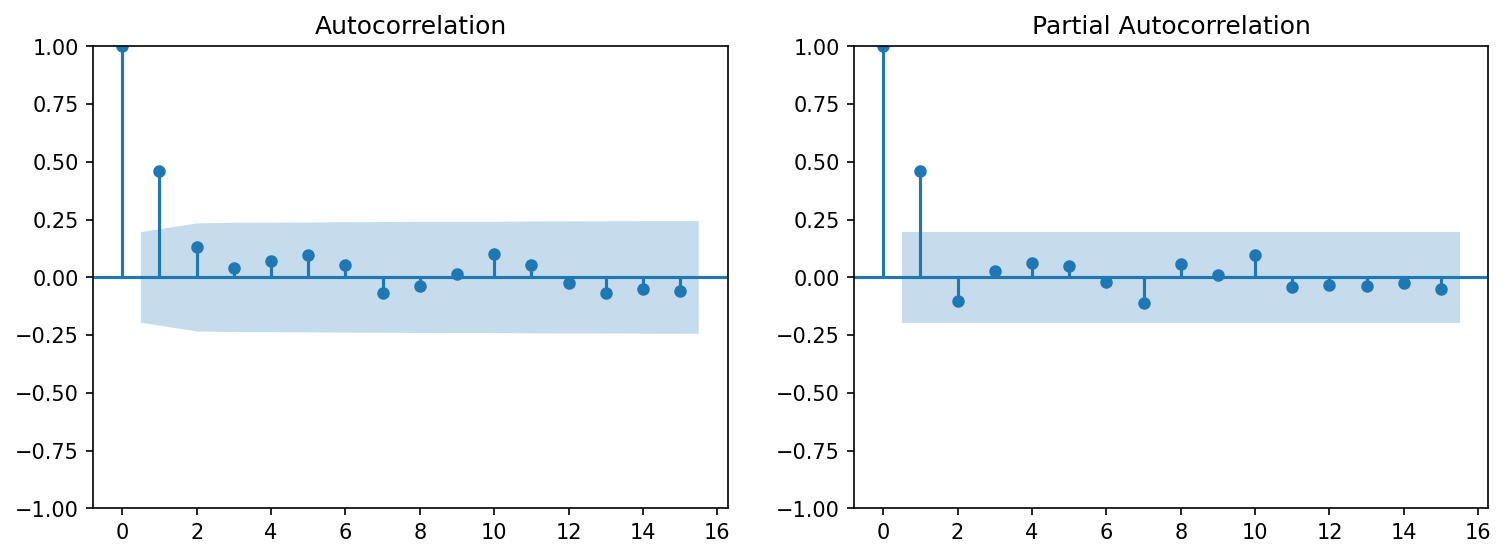

In [10]:
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(data, lags=15, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(data, lags=15, ax=ax2)
plt.savefig(fname='相关图.png')

# 识别模型
series = pd.Series(data)
model = auto_arima(series, seasonal= False, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

结合自相关系数和偏自相关系数，以及AIC判断，最终确定最优模型：  
$$ARIMA(1,0,0)$$

## 四、模型拟合

In [11]:
# 拟合模型
mod = sm.tsa.statespace.SARIMAX(data, order=(1,0,0))
res = mod.fit() 
print(res.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16751D+00    |proj g|=  4.73543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   3.611D-05   3.168D+00
  F =   3.1675055109340189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7697      0.057    

 This problem is unconstrained.


最终确定模型为：
$$X_t=0.7697X_{t-1}+\epsilon_t$$  
且参数检验p值均小于0.05，说明在95%的置信区间下检验均通过

## 五、均值模型整体效果检验
通过通过验证模型对信息的提取是否充分，即残差是否为白噪声序列，来判断模型的整体效果。  
若残差为白噪声，则均值模型足够，建模结束。  
若残差不是白噪声，则说明残差中还有信息，再进一步检验是自相关还是异方差。  
### 5.1判断标准化残差是否服从标准正态分布
检验：$$E(\epsilon_t)=0$$
$$D(\epsilon_t)=1$$
$$\epsilon_t服从N(0,1)$$
### 5.2残差的自相关函数
计算判断各个残差之间是否相关
### 5.3LB检验
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$

残差序列： [ 9.00000000e+00  5.07296411e+00 -1.23604786e+00  5.84263476e+00
  7.63952141e-01  2.30329345e+00  3.03293451e-01 -4.15736524e+00
 -1.53934131e+00  7.00000000e+00  4.61230542e+00  1.30329345e+00
 -2.92703589e+00 -2.07868262e+00  6.23032935e+00 -3.87694584e-01
  4.15164673e+00  2.84263476e+00 -1.92703589e+00  1.15164673e+00
  2.15164673e+00 -6.18023930e-01 -1.20786826e+01 -2.00729641e+01
  3.27811077e+01  7.63952141e-01  2.30329345e+00  3.03293451e-01
  1.84263476e+00  2.84263476e+00  7.07296411e+00 -3.77538917e+00
 -1.38769458e+00 -2.07868262e+00  2.30329345e-01  1.23032935e+00
  4.46065869e+00  2.38197607e+00  1.61230542e+00 -7.38769458e+00
  5.39341310e-01  7.76967065e+00  6.61230542e+00  7.63952141e-01
  2.30329345e+00 -3.69670655e+00  5.92131738e+00  3.07296411e+00
  1.30329345e+00 -1.92703589e+00  1.51646725e-01 -7.86826197e-02
  4.69098804e+00  1.61230542e+00  6.12305416e-01  3.38197607e+00
 -3.15736524e+00  1.69098804e+00 -8.07868262e+00 -1.01516467e+01
  1.17753892e+01  5

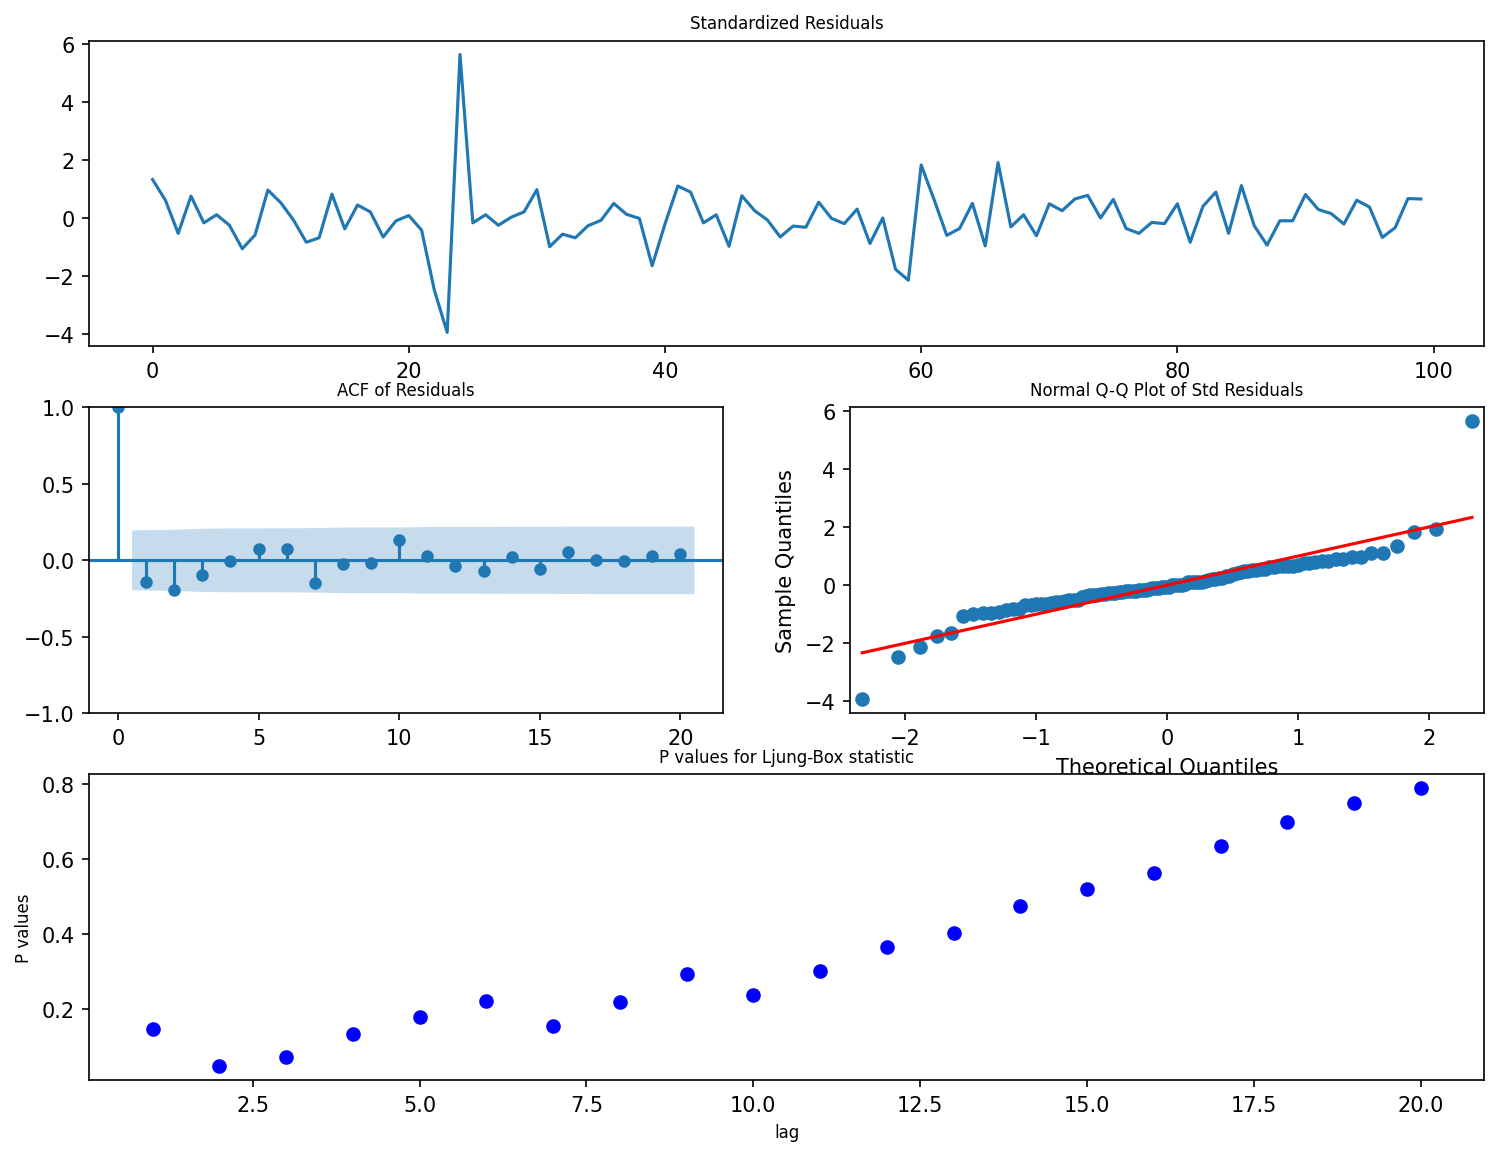

In [12]:
## 整体效果检验
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,21)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

子图1为标准化残差图，观察可知推测均值为0，但可能残差存在异方差性；  
子图2为残差自相关图，各残差之间不相关；  
子图3为Q-Q图，残差为为正态分布；  
子图4为Ljung-Box统计量，p值大于0.05，不拒绝原假设认为残差为白噪声序列，但在滞后阶数为2时检验p值小于0.05，为非白噪声；  
结论：残差中可能存在信息，包括自相关与异方差的情况，因此除了均值模型，还需要对残差进行建模 。

## 六、残差的自相关性检验（DW检验）
原假设$$ H0：P = 0（残差项不存在一阶序列相关）$$
备择假设$$  H1：P ≠ 0（残差项存在一阶序列相关）$$
检验统计量：$$DW=\sum_{t = 2}^{n}\frac{(e_{t}-e_{t - 1})^{2}}{\sum_{t = 2}^{n}e_{t}^{2}}$$
判断$$DW < d_l：拒绝H0，存在正相关性$$
$$d_l < DW < d_u：无法做出确切判断$$
$$d_u < DW < 4 - d_u：接受H0，不存在自相关性$$
$$4 - d_u < DW < 4 - d_l：无法做出确切判断$$
$$DW > 4 - d_l：拒绝H0，存在负相关性$$
其中$d_l$为DW检验统计量的下临界值，$d_u$为DW检验统计量的上临界值。

In [13]:
## 残差的自相关检验
# DW检验
dw_stat = durbin_watson(residuals)
print("DW统计量:", dw_stat)
if dw_stat < 1:
    print("可能存在正自相关")
elif dw_stat > 3:
    print("可能存在负自相关")
else:
    print("不存在一阶自相关")

DW统计量: 2.0812441355020312
不存在一阶自相关


## 七、异方差性检验（White检验）

原假设H0：残差项中不存在异方差  
备择假设H1：残差项中存在异方差  
采用LM统计量作为检验统计量：
$$
LM=nR^2
$$

In [14]:
# White 检验
exog = np.column_stack((np.ones(len(data)), data))
white_test_results = het_white(res.resid, exog)
print(f"White 检验统计量：{white_test_results[0]}")
print(f"p 值：{white_test_results[1]}")

if white_test_results[1] < 0.05:
    print('存在异方差性。')
else:
    print('不存在异方差性。')

White 检验统计量：14.645757228757573
p 值：0.0006602588423967548
存在异方差性。


## 八、ARCH模型

In [15]:
# arch模型
am = arch_model(residuals, mean='Zero', vol='ARCH', p=2).fit(disp="off")
print(am.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.010
Vol Model:                       ARCH   Log-Likelihood:               -297.186
Distribution:                  Normal   AIC:                           600.373
Method:            Maximum Likelihood   BIC:                           608.188
                                        No. Observations:                  100
Date:                Tue, Nov 12 2024   Df Residuals:                      100
Time:                        15:58:52   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         15.2335      2.963      5.142  2.725e-07 

参数检验结果表明$\alpha_2$的p值大于0.05不显著  
因此ARIMA-ARCH模型为  
$$\begin{cases}
X_t=0.7697X_{t-1}+\epsilon_t  \\ 
var(\epsilon_t)=h_t  \\ 
h_t = 15.2335 +  0.162 \epsilon_{t-1}^2
\end{cases}$$

## 九、ARCH模型整体效果的检验
主要检验正态性
### 9.1图检验
通过Q-Q图和直方图检验

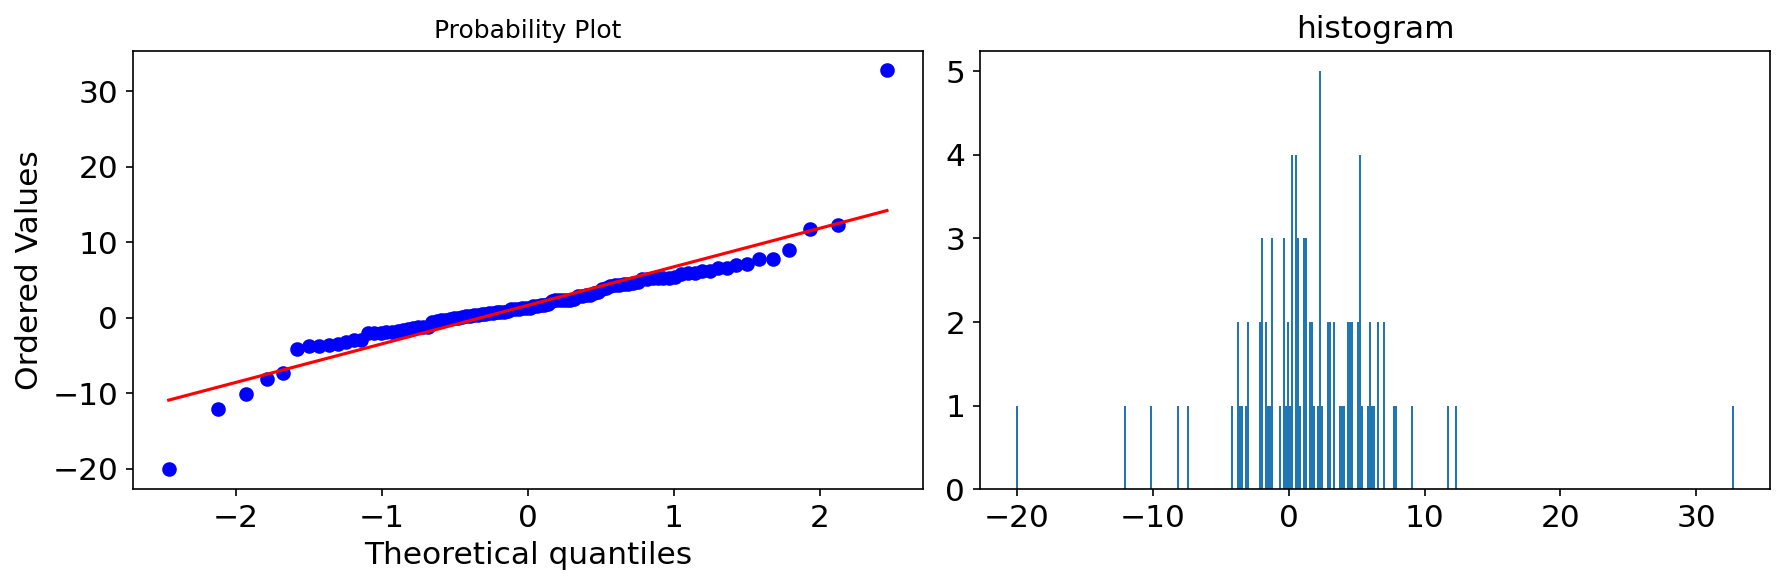

In [21]:
## ARCH模型的检验
# 正态性图检验
# 绘制 QQ 图
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
res1 = st.probplot(residuals, plot=ax1)
ax1.set_ylabel(ylabel="Ordered Values", fontsize=15)
ax1.set_xlabel(xlabel="Theoretical quantiles", fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

# 绘制直方图
ax2 = fig.add_subplot(122)
ax2.hist(residuals, bins=360)
ax2.set_title('histogram', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig(fname='残差的正态性检验.png')

### 9.2JB检验
原假设$$H0:\frac{\epsilon_t}{\sqrt{h_t}}\sim N(0,1)$$
备择假设$$H1:\frac{\epsilon_t}{\sqrt{h_t}}不服从N(0,1)$$
检验统计量$$JB=\frac{T}{6}b^2_1+\frac{T}{24}(b^2_2-3)^2\sim\chi^{2}(2)$$

In [20]:
# JB检验
def self_JBtest(y):
    # 计算Jarque-Bera统计量和p值
    JB, pvalue= jarque_bera(y)
    return np.array([JB, pvalue])

# 对残差进行JB检验
jb_results = self_JBtest(residuals)
print(f"Jarque-Bera统计量: {jb_results[0]}")
print(f"p值: {jb_results[1]}")
if jb_results[1] < 0.05:
    print("拒绝原假设，残差不服从正态分布。")
else:
    print("不能拒绝原假设，残差在JB检验下服从正态分布。")

Jarque-Bera统计量: 494.3263135310832
p值: 4.554124372229695e-108
拒绝原假设，残差不服从正态分布。


老师你说的残差不服从正态分布也没关系：）

## 十、模型的预测

未来三个数据的预测值：[10.00571851  7.70110792  5.92731678]
        mean   mean_se  90%lower   90%upper  95%lower   95%upper
0  10.005719  5.720551  0.596250  19.415187 -1.206355  21.217792
1   7.701108  7.218766 -4.172706  19.574922 -6.447414  21.849630
2   5.927317  7.974625 -7.189774  19.044408 -9.702661  21.557295


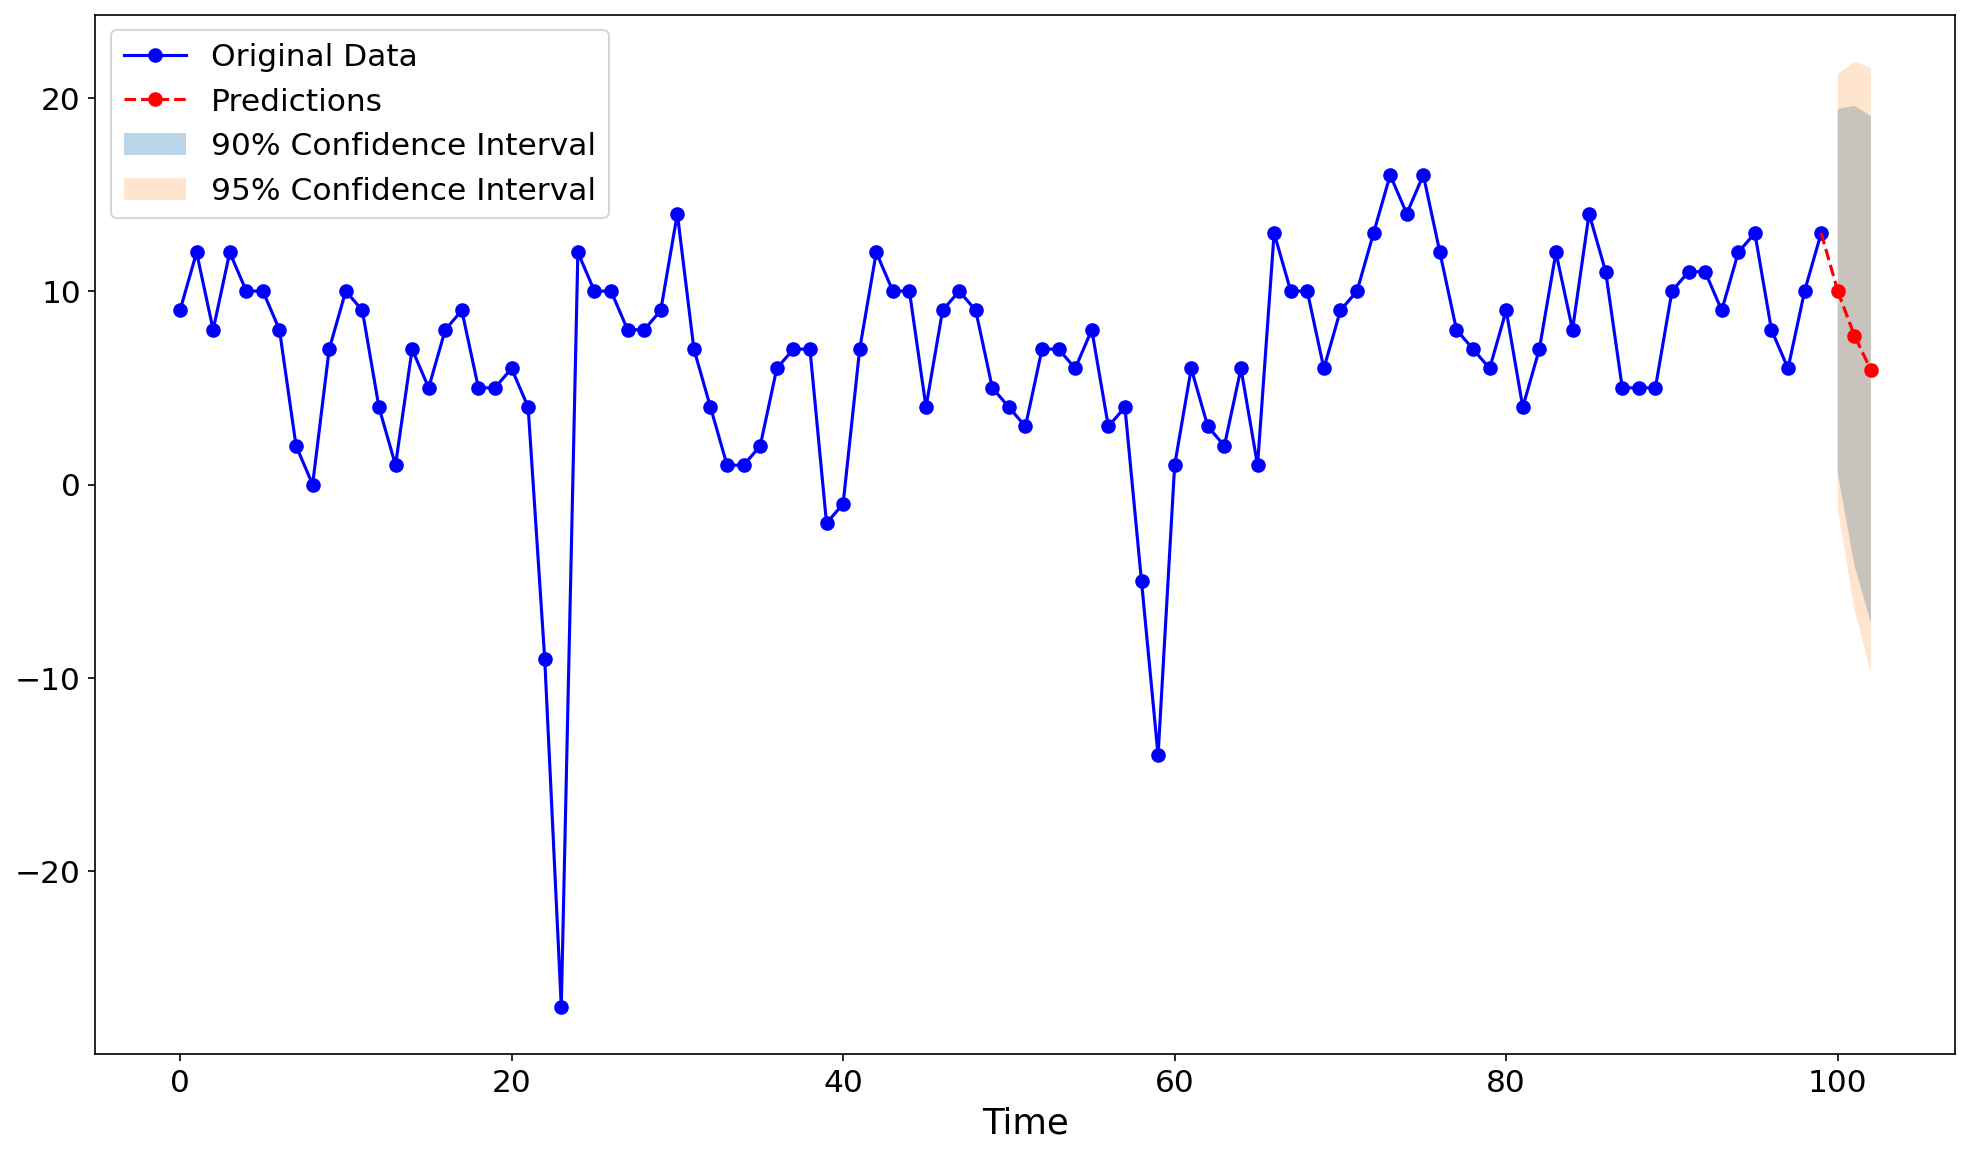

In [9]:
# 预测未来三个数据
n_periods = 3

forecast = res.forecast(steps=n_periods)
df_fore = res.get_forecast(steps=n_periods)

print(f"未来三个数据的预测值：{forecast}")

## 模型的预测

confint1=df_fore.summary_frame(alpha=0.10)
confint2=df_fore.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print(confint)

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [data[last_data_index], confint["mean"][last_pred_index-len(data)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='预测结果.png')